In [1]:
import sys
sys.path.append('../')
import polars as pl
from pathlib import Path
from sklearn.linear_model import LinearRegression
from datetime import time, datetime
import numpy as np
from base.impactpy.model.subroutines import (
	compute_OW_impact, simple_regression, enhance_data, SampleGroup
)

In [2]:
p = Path().resolve().parents[0] / 'data' / 'raw_bin_samples' / 'clean.arrow'
lf = pl.scan_ipc(p)

In [3]:
df = lf.collect()

In [4]:
df

symbol,timestamp,price,trade
cat,datetime[μs],f64,i32
"""ADSK""",2019-01-02 09:30:00,125.205,-287
"""ADSK""",2019-01-02 09:30:10,124.61,20
"""ADSK""",2019-01-02 09:30:20,124.61,0
"""ADSK""",2019-01-02 09:30:30,125.155,200
"""ADSK""",2019-01-02 09:30:40,125.705,-385
…,…,…,…
"""ADS""",2019-12-27 15:59:20,110.915,0
"""ADS""",2019-12-27 15:59:30,110.95,0
"""ADS""",2019-12-27 15:59:40,110.92,0


In [5]:
push = df.select(pl.col('symbol').unique()).with_columns(push=1)

half_life = 300
beta = np.log(2) / half_life
bin_duration = 10
alpha = np.exp(-beta * bin_duration)

In [6]:
df = enhance_data(df, 30)

In [7]:
df = df.filter(
	pl.col('timestamp').dt.month().ge(2)
	& pl.col('timestamp').dt.month().le(5)
)

In [8]:
df = compute_OW_impact(df, push, alpha)

In [9]:
n_periods = half_life // bin_duration

df = df.with_columns(
	pl.col('price').diff(n_periods).over('symbol').mul(100).alias('return'),
	pl.col('impact').diff(n_periods).over(['symbol', pl.col('timestamp').dt.date()]).alias('impact_diff')
)

In [33]:
train_df = (df
	.filter(
		pl.col('timestamp').dt.time().ge(time(10))
		& pl.col('timestamp').dt.time().le(time(16))
	)
	.with_columns(
		group=pl.col('symbol').cast(pl.Categorical),
		sample=pl.when(pl.col('timestamp').dt.month().eq(5))
			.then(SampleGroup.TEST.value)
			.otherwise(SampleGroup.TRAIN.value)
	)
)

In [34]:
train_df

symbol,timestamp,price,trade,vola,adv,push,impact,return,impact_diff,group,sample
cat,datetime[μs],f64,f64,f64,f64,i32,f64,f64,f64,i32,i32
"""ADSK""",2019-02-01 10:00:00,147.965,-0.000177,0.034882,250607.285714,1,-0.000177,-0.5,0.000074,1,1
"""ADSK""",2019-02-01 10:00:10,147.965,-0.000173,0.034882,250607.285714,1,-0.000173,-4.0,0.000081,1,1
"""ADSK""",2019-02-01 10:00:20,147.96,-0.000203,0.034882,250607.285714,1,-0.000203,-6.0,0.000045,1,1
"""ADSK""",2019-02-01 10:00:30,147.725,-0.000212,0.034882,250607.285714,1,-0.000212,-29.5,0.00003,1,1
"""ADSK""",2019-02-01 10:00:40,147.755,-0.000164,0.034882,250607.285714,1,-0.000164,-26.5,0.000073,1,1
…,…,…,…,…,…,…,…,…,…,…,…
"""ADS""",2019-05-31 15:59:20,137.52,-0.000254,0.029309,81173.047619,1,-0.000254,4.5,0.000215,1,3
"""ADS""",2019-05-31 15:59:30,137.555,-0.000227,0.029309,81173.047619,1,-0.000227,5.5,0.00019,1,3
"""ADS""",2019-05-31 15:59:40,137.56,-0.000238,0.029309,81173.047619,1,-0.000238,9.0,0.000205,1,3


In [35]:
res = simple_regression(train_df, 'impact_diff', 'return', 'group', 'sample')

In [36]:
res

group,sample,e_x,e_y,e_xx,e_yy,e_xy,n,beta,alpha,mse,rmse,tss,rss,rsq
i32,i32,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64
1,1,3.6174e-7,0.096396,2.8917e-8,988.80643,0.001037,6459229,35853.376641,0.083426,951.625714,30.848431,6.3869e9,6.1468e9,0.037593
1,3,2.7753e-7,0.044306,2.7654e-8,1499.730681,0.001107,2329558,35853.376641,0.083426,1455.923442,38.156565,3.4937e9,3.3917e9,0.029209


<Axes: ylabel='Frequency'>

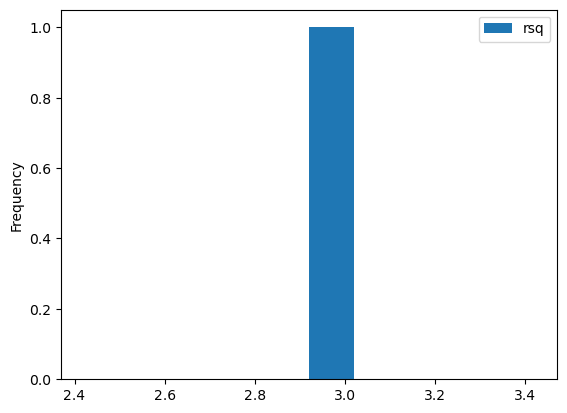

In [41]:
res.filter(pl.col('sample').eq(SampleGroup.TEST.value)).select(pl.col('rsq').mul(100)).to_pandas().plot(kind='hist')

In [38]:
datetime(2000, 1, 1).month

1